<a href="https://colab.research.google.com/github/kinslersi/LogisticRegression/blob/main/linear_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pandas
!pip install numpy
!pip install sklearn
!pip install matplotlib
!pip install seaborn 
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: 

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [5]:
# Exploratory analysis

df=pd.read_csv('Debernardi et al 2020 data.csv')
pd.set_option('display.max_columns',None)
print(df.info())
print(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sample_id                590 non-null    object 
 1   patient_cohort           590 non-null    object 
 2   sample_origin            590 non-null    object 
 3   age                      590 non-null    int64  
 4   sex                      590 non-null    object 
 5   diagnosis                590 non-null    int64  
 6   stage                    199 non-null    object 
 7   benign_sample_diagnosis  208 non-null    object 
 8   plasma_CA19_9            350 non-null    float64
 9   creatinine               590 non-null    float64
 10  LYVE1                    590 non-null    float64
 11  REG1B                    590 non-null    float64
 12  TFF1                     590 non-null    float64
 13  REG1A                    306 non-null    float64
dtypes: float64(6), int64(2), o

In [6]:
# preprocessing

data=df.drop(['sample_id','patient_cohort','sample_origin','stage','benign_sample_diagnosis','plasma_CA19_9','REG1A'],axis=1)
sex_number={'F':0,"M":1}
data['sex'].replace(sex_number,inplace=True)  # set female as 0, male as 1
print(data.head(10))

   age  sex  diagnosis  creatinine     LYVE1      REG1B        TFF1
0   33    0          1     1.83222  0.893219   52.94884  654.282174
1   81    0          1     0.97266  2.037585   94.46703  209.488250
2   51    1          1     0.78039  0.145589  102.36600  461.141000
3   61    1          1     0.70122  0.002805   60.57900  142.950000
4   62    1          1     0.21489  0.000860   65.54000   41.088000
5   53    1          1     0.84825  0.003393   62.12600   59.793000
6   70    1          1     0.62205  0.174381  152.27700  117.516000
7   58    0          1     0.89349  0.003574    3.73000   40.294000
8   59    0          1     0.48633  0.001945    7.02100   26.782000
9   56    0          1     0.61074  0.278778   83.92800   19.185000


In [7]:
# split data 

y=data['diagnosis']
x=data.drop(['diagnosis'],axis=1)

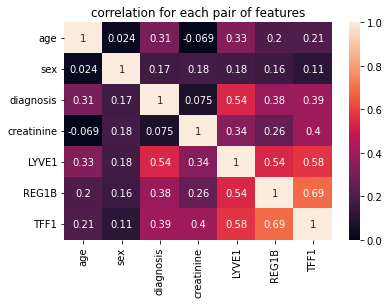

In [8]:
# check the correction 

corr=data.corr()
sns.heatmap(corr,vmax=0,vmin=1,annot=True,cbar=True)
plt.title('correlation for each pair of features')
plt.show()   # assume that exceed 0.7 correlation might causing multicollinearity to reduced reg coefficient accurancy

In [9]:
# Detecting Multicollinearity
def compute_vif(considered_variables):
    z=data[considered_variables]
    # create dataframe to restore vif
    vif=pd.DataFrame()
    vif['variables']=z.columns
    vif['vif']=[variance_inflation_factor(z.values, i) for i in range(len(z.columns))]
    return vif
Multicollinearity1=compute_vif(x.columns)
print(Multicollinearity1)     # vif=1 means no correlation, vif>5or10 is too high to contributing multicollinearity

    variables       vif
0         age  3.320921
1         sex  2.045946
2  creatinine  3.077264
3       LYVE1  3.099881
4       REG1B  2.721350
5        TFF1  3.094782


In [10]:
""" 
Since creatinine and all the other proteins are important for the diagnosis, 
we'll try to remove other features that might not be important. After taking a look 
at the correlation plot, we'll try to remove "sex" and see if the vif scores get any better 
"""
x1=x.drop(['sex','age'],axis=1)
Multicollinearity2=compute_vif(x1.columns)
print(Multicollinearity2)

    variables       vif
0  creatinine  2.004829
1       LYVE1  2.734736
2       REG1B  2.686825
3        TFF1  3.040989


In [11]:
# define the multinomial logistic regression model
# test six variables fitting the model('age', 'sex', 'creatinine', 'LYVE1', 'REG1B', 'TFF1')
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
reg1=LogisticRegression(multi_class='multinomial', solver='lbfgs')
reg1.fit(x_train,y_train)   # 比較係數之間對y的影響程度大小再標準化，因為需要放在相同的尺度上，預測時做標準化會存在誤差
print('對test預測:',reg1.predict(x_test))
print('x準確率:',reg1.score(x_test,y_test))

# test four variables fitting the model('creatinine', 'LYVE1', 'REG1B', 'TFF1')
x1_train,x1_test,y_train,y_test=train_test_split(x1,y,test_size=0.2)
reg2=LogisticRegression(multi_class='multinomial', solver='lbfgs')
reg2.fit(x1_train,y_train)  
print('對test預測:',reg2.predict(x1_test))
print('x1準確率:',reg2.score(x1_test,y_test))

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


對test預測: [2 2 2 2 3 1 2 2 1 2 2 2 1 3 2 2 2 3 3 3 3 3 1 1 2 3 2 3 2 3 2 2 3 1 3 2 2
 1 1 2 1 1 3 2 1 2 1 1 2 1 2 3 2 2 1 3 2 3 3 2 3 2 3 2 3 2 1 2 1 1 2 2 3 2
 3 3 1 2 3 2 1 1 1 2 3 3 2 1 3 2 1 1 1 2 3 2 1 3 3 1 1 1 2 3 1 2 2 2 2 3 3
 3 1 3 3 1 2 3]
x準確率: 0.5169491525423728
對test預測: [3 1 1 3 2 1 1 2 1 1 1 1 3 2 3 1 2 1 2 1 3 3 2 1 1 1 2 1 3 3 1 1 1 3 1 2 3
 1 2 3 2 1 1 3 2 2 3 2 2 2 1 3 3 3 2 3 1 3 1 3 2 2 1 1 2 2 2 1 1 3 1 1 1 1
 3 1 2 3 1 2 1 3 1 1 3 1 3 3 3 1 1 1 1 1 2 3 3 3 3 1 2 1 1 2 1 3 1 3 1 1 3
 1 1 2 2 1 1 1]
x1準確率: 0.5932203389830508


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
# multiple coefficient regresson model intercept and coefficient
print('reg2 intercept:',reg2.intercept_)
print('reg2 coefficeint:',reg2.coef_)

reg2 intercept: [ 0.48574841  0.23088461 -0.71663302]
reg2 coefficeint: [[ 5.37457578e-01 -1.24032562e-01 -5.54312228e-04 -1.72490896e-03]
 [ 1.28232441e-01 -1.09075199e-01 -8.27555854e-04  8.14370567e-04]
 [-6.65690020e-01  2.33107761e-01  1.38186808e-03  9.10538397e-04]]
